In [2]:
import pickle

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay

try:
    from sklearnex import patch_sklearn
    patch_sklearn()
except ModuleNotFoundError:
    pass

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
try:
    X = pd.read_feather("./data/train_data.feather")
    y = pd.read_feather("./data/train_label.feather")

except FileNotFoundError:
    X = pd.read_csv("./data/train_data.csv", parse_dates=["date_recorded"], dtype_backend="pyarrow")
    y = pd.read_csv("./data/train_label.csv", dtype_backend="pyarrow")
    # waterpoint name and subvillage are redundant and have all unique values
    X = X.drop(["wpt_name", "subvillage"], axis="columns")
    # remove dummified columns
    for feature in X.select_dtypes("string").columns:
        dummies = pd.get_dummies(X[feature], prefix=feature, prefix_sep=" ")
        X.drop(feature, axis="columns", inplace=True)
        X = pd.concat([X, dummies], axis='columns')
    # convert labels to numeric
    y["status_group"].replace(
        ['functional', 'non functional', 'functional needs repair'],
        [0, 1, 2],
        inplace=True
        )

    y.to_feather("./data/train_label.feather")
    X.to_feather("./data/train_data.feather")

    # write new columns to file
    X.columns.to_series().to_csv("./data/columns.csv")

In [4]:
# drop rows with missing values
df = pd.concat([X,y], axis="columns")
df = df.dropna(axis=0)
X, y = df.iloc[:,:-1], df.iloc[:,-1]

In [5]:
X

,id,amount_tsh,date_recorded,gps_height,longitude,latitude,num_private,region_code,district_code,population,...,waterpoint_type hand pump,waterpoint_type improved spring,waterpoint_type other,waterpoint_type_group cattle trough,waterpoint_type_group communal standpipe,waterpoint_type_group dam,waterpoint_type_group hand pump,waterpoint_type_group improved spring,waterpoint_type_group other,id
0,69572,6000.0,2011-03-14 00:00:00,1390,34.938093,-9.856322,0,11,5,109,...,False,False,False,False,True,False,False,False,False,69572
2,34310,25.0,2013-02-25 00:00:00,686,37.460664,-3.821329,0,21,4,250,...,False,False,False,False,True,False,False,False,False,34310
3,67743,0.0,2013-01-28 00:00:00,263,38.486161,-11.155298,0,90,63,58,...,False,False,False,False,True,False,False,False,False,67743
4,19728,0.0,2011-07-13 00:00:00,0,31.130847,-1.825359,0,18,1,0,...,False,False,False,False,True,False,False,False,False,19728
5,9944,20.0,2011-03-13 00:00:00,0,39.172796,-4.765587,0,4,8,1,...,False,False,False,False,True,False,False,False,False,9944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59395,60739,10.0,2013-05-03 00:00:00,1210,37.169807,-3.253847,0,3,5,125,...,False,False,False,False,True,False,False,False,False,60739
59396,27263,4700.0,2011-05-07 00:00:00,1212,35.249991,-9.070629,0,11,4,56,...,False,False,False,False,True,False,False,False,False,27263
59397,37057,0.0,2011-04-11 00:00:00,0,34.017087,-8.750434,0,12,7,0,...,True,False,False,False,False,False,True,False,False,37057
59398,31282,0.0,2011-03-08 00:00:00,0,35.861315,-6.378573,0,1,4,0,...,True,False,False,False,False,False,True,False,False,31282


In [6]:
if False:
    # impute takes forever
    dtree = Pipeline(
        [
            ('Imputer', KNNImputer(n_neighbors=3, weights='distance')),
            ('Classifier', DecisionTreeClassifier(max_depth=3)),
        ]
    )
    cross_val_score(dtree,X.select_dtypes(exclude="datetime"),y, n_jobs=-1)

In [7]:
# dtree = DecisionTreeClassifier()
# dtree.fit(X.select_dtypes(exclude="datetime"),y)
# plt.figure(dpi=400, figsize=(15,15))
# tplot = plot_tree(dtree, feature_names=list(X.select_dtypes(exclude="datetime").columns), fontsize=15)
# dtree.score(X.select_dtypes(exclude="datetime"), y)

In [9]:
try:
    with open("./models/forest_0.pickle", "rb") as f:
        forest = pickle.load(f)
except FileNotFoundError:
    forest = RandomForestClassifier(
        # max_depth=4,
        max_features="log2",
        bootstrap=True,
        max_samples=1000,
        n_jobs=-1,
        class_weight="balanced_subsample",
        # warm_start=True,
        random_state=51
        )
    forest.fit(X.select_dtypes(exclude="datetime"),y)
    with open("./models/forest_0.pickle", "wb") as f:
        pickle.dump(forest, f, pickle.HIGHEST_PROTOCOL)

forest.score(X.select_dtypes(exclude="datetime"), y)


0.7666898143803608

In [ ]:
groups = y.unique()
pred = forest.predict(X.select_dtypes(exclude="datetime"))

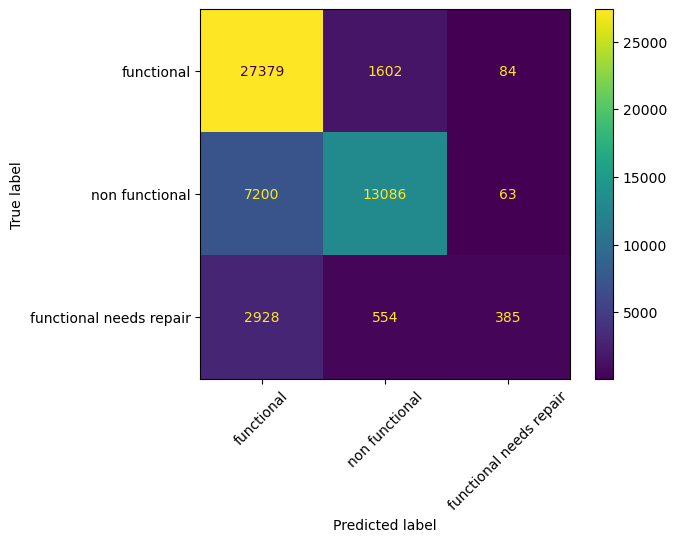

In [ ]:
fig = ConfusionMatrixDisplay.from_predictions(y, pred, display_labels=['functional', 'non functional', 'functional needs repair'])
_ = plt.xticks(rotation=45)

NOTES ON RANDOM FOREST:

very bad at predicting 'functional needs repair'  
training conditions could be tweaked for better performance  
could use train test split for better evaluation  
might consider using under-sampling to level out the number of samples from functional needs repair in training
